In [51]:
import pickle
from recbole.config import Config
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

list_dataset = [
    "Amazon_Luxury_Beauty",
    "lastfm",
    "ml-1m",
    "book-crossing",
    "Amazon_Industrial_and_Scientific",
    "Amazon_Digital_Music"
]

item_count = {
    "Amazon_Luxury_Beauty":791,
    "lastfm":2823,
    "ml-1m":3307,
    "book-crossing":7455,
    "Amazon_Industrial_and_Scientific":3569,
    "Amazon_Digital_Music":9462
}


result_dict = dict()
result_per_item = dict()
for dataset in list_dataset:


    config = Config(
                model="Pop", 
                dataset=dataset, 
                config_file_list=["../RecBole/recbole/properties/overall.yaml"],
                )


    with open(f"../train_val_test/{dataset}_test.pickle","rb") as f:
        data = pickle.load(f)
    test = pd.DataFrame(data)

    item_id = config.final_config_dict["ITEM_ID_FIELD"]

    test = test.groupby("user_id")\
        .agg(lambda x: [x for x in x])\
        [item_id]
    

    count_rel_user_per_item = Counter(test.sum())

    for item_id in range(1, item_count[dataset]+1):
        if item_id not in count_rel_user_per_item:
            count_rel_user_per_item[item_id] = 0
    
    count_rel_user_per_item  = pd.Series(count_rel_user_per_item).value_counts().sort_index()
    more_than_10 = count_rel_user_per_item[count_rel_user_per_item.index>10].sum()
    count_rel_user_per_item = count_rel_user_per_item[count_rel_user_per_item.index<=10]
    count_rel_user_per_item[">10"] = more_than_10
    
    result_per_item[dataset] = count_rel_user_per_item.to_dict()

    test = test.apply(len)

    aggregated = test.value_counts().sort_index()
    more_than_10 = aggregated[aggregated.index>10].sum()
    aggregated = aggregated[aggregated.index<=10]
    aggregated[">10"] = more_than_10

    result_dict[dataset] = aggregated.to_dict()

In [64]:
df = pd.DataFrame(result_dict)
df = df.loc[[1,2,3,4,5,6,7,8,9,10,">10"]]
df = df.fillna(0)
df

,Amazon_Luxury_Beauty,lastfm,ml-1m,book-crossing,Amazon_Industrial_and_Scientific,Amazon_Digital_Music
1,1504.0,104.0,284,4488,6505.0,10838
2,96.0,220.0,748,480,56.0,515
3,26.0,488.0,576,258,8.0,200
4,10.0,974.0,426,132,2.0,77
5,2.0,73.0,345,71,2.0,41
6,3.0,0.0,324,61,1.0,27
7,2.0,0.0,276,43,0.0,16
8,1.0,0.0,222,27,0.0,12
9,0.0,0.0,226,20,0.0,9
10,0.0,0.0,195,15,0.0,4


In [65]:
df.loc[10] = df.loc[10] + df.loc[">10"]
df = df.iloc[:-1]

In [66]:
df_cum_sum = df.iloc[::-1].cumsum().iloc[::-1]
df_cum_sum = df_cum_sum.astype(int)


In [67]:
df_cum_sum = df_cum_sum.rename(columns={"Amazon_Digital_Music":"amazon-dm",
                            "Amazon_Industrial_and_Scientific":"amazon-is",
                            "Amazon_Luxury_Beauty":"amazon-lb",
                            "book-crossing":"book-x",
                            })

In [68]:
df_cum_sum

,amazon-lb,lastfm,ml-1m,book-x,amazon-is,amazon-dm
1,1644,1859,6038,5639,6574,11750
2,140,1755,5754,1151,69,912
3,44,1535,5006,671,13,397
4,18,1047,4430,413,5,197
5,8,73,4004,281,3,120
6,6,0,3659,210,1,79
7,3,0,3335,149,0,52
8,1,0,3059,106,0,36
9,0,0,2837,79,0,24
10,0,0,2611,59,0,15


In [69]:
import numpy as np
import seaborn as sns

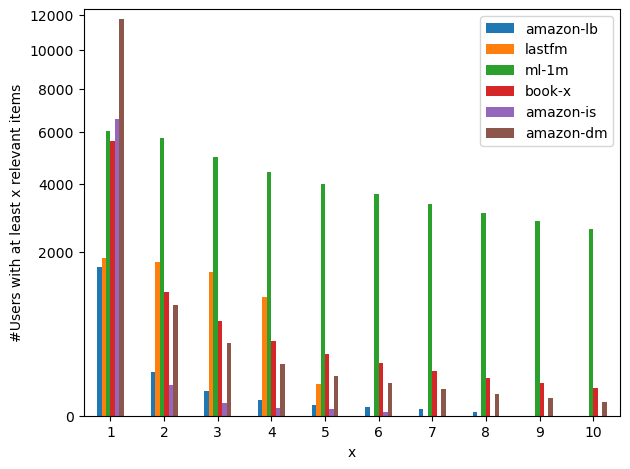

In [70]:
fig = df_cum_sum.plot(kind="bar",rot=0, xlabel="x", ylabel="#Users with at least x relevant items")

def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2 * np.sign(x)
fig.set_yscale('function', functions=(forward,inverse))
plt.tight_layout()

In [74]:
df = pd.DataFrame(result_per_item)
df = df.fillna(0)
df

,Amazon_Luxury_Beauty,lastfm,ml-1m,book-crossing,Amazon_Industrial_and_Scientific,Amazon_Digital_Music
0,374,934,81,2928,1045,3450
1,168,841,157,2444,1045,2926
2,77,391,183,1089,630,1538
3,41,201,180,487,343,668
4,28,120,142,201,177,347
5,14,72,146,100,109,174
6,18,58,113,64,60,105
7,13,38,96,32,40,63
8,7,30,100,28,25,53
9,7,18,96,23,15,31


In [75]:
df.sum()

Amazon_Luxury_Beauty                 791
lastfm                              2823
ml-1m                               3307
book-crossing                       7455
Amazon_Industrial_and_Scientific    3569
Amazon_Digital_Music                9462
dtype: int64

In [78]:
df.loc[0] / df.sum() * 100

Amazon_Luxury_Beauty                47.281922
lastfm                              33.085370
ml-1m                                2.449350
book-crossing                       39.275654
Amazon_Industrial_and_Scientific    29.279910
Amazon_Digital_Music                36.461636
dtype: float64

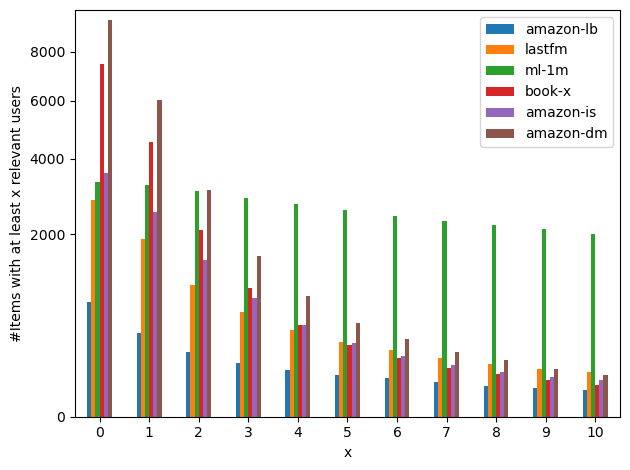

In [61]:
df.loc[10] = df.loc[10] + df.loc[">10"]
df = df.iloc[:-1]
df_cum_sum = df.iloc[::-1].cumsum().iloc[::-1]
df_cum_sum = df_cum_sum.astype(int)

df_cum_sum = df_cum_sum.rename(columns={"Amazon_Digital_Music":"amazon-dm",
                            "Amazon_Industrial_and_Scientific":"amazon-is",
                            "Amazon_Luxury_Beauty":"amazon-lb",
                            "book-crossing":"book-x",
                            })

fig = df_cum_sum.plot(kind="bar",rot=0, xlabel="x", ylabel="#Items with at least x relevant users")

def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2 * np.sign(x)
fig.set_yscale('function', functions=(forward,inverse))
plt.tight_layout()

In [82]:
df_cum_sum.loc[6]

amazon-lb       6
lastfm          0
ml-1m        3659
book-x        210
amazon-is       1
amazon-dm      79
Name: 6, dtype: int32